# Метод ближайших соседей

Для начала подключим библиотеки, которые нам понадобятся. Если библиотека не установлена, нужно выполнить команду:

!pip install <название библиотеки>

Например:

!pip install sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Загрузим данные в наш ноутбук. Чаще всего данные хранят в двух форматах: csv (comma-separated file) и excel. Загрузка данных производится командами pandas.read_csv и pandas.read_excel. Аргументом подается путь к файлу (полный или относительный). Для read_csv часто бывает нужен еще аргумент sep, который задает символ, разделяющий значения в файле.
Документация: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [4]:
data = pd.read_csv('boston_crime.csv', sep=',')
# Посмотрим на несколько записей из набора данных
data.head(10)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I192062057,619,Larceny,LARCENY ALL OTHERS,B3,444,NaN,2019-08-08 21:15:00,2019,8,Thursday,21,Part One,BLUE HILL AVE,42.295764,-71.087560,"(42.29576380, -71.08756002)"
1,I192062054,3115,Investigate Person,INVESTIGATE PERSON,D4,156,NaN,2019-08-08 21:04:00,2019,8,Thursday,21,Part Three,W CONCORD ST,42.339620,-71.076992,"(42.33961962, -71.07699237)"
2,I192062049,1402,Vandalism,VANDALISM,NaN,,NaN,2019-08-08 21:19:00,2019,8,Thursday,21,Part Two,NaN,NaN,NaN,"(0.00000000, 0.00000000)"
3,I192062044,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,D4,162,NaN,2019-08-08 19:31:00,2019,8,Thursday,19,Part Three,HARRISON AVE,42.344967,-71.063822,"(42.34496729, -71.06382224)"
4,I192062043,3201,Property Lost,PROPERTY - LOST,D4,141,NaN,2019-08-08 19:15:00,2019,8,Thursday,19,Part Three,NEWBURY ST,42.348406,-71.086883,"(42.34840576, -71.08688339)"
5,I192062042,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,D4,617,NaN,2019-08-08 19:08:00,2019,8,Thursday,19,Part Three,HUNTINGTON AVE,42.337923,-71.095266,"(42.33792266, -71.09526598)"
6,I192062039,3115,Investigate Person,INVESTIGATE PERSON,C11,359,NaN,2019-08-08 20:39:00,2019,8,Thursday,20,Part Three,WASHINGTON ST,42.294814,-71.072009,"(42.29481426, -71.07200871)"
7,I192062036,3115,Investigate Person,INVESTIGATE PERSON,B2,585,NaN,2019-08-08 20:09:00,2019,8,Thursday,20,Part Three,PARKER HILL AVE,42.330335,-71.107499,"(42.33033485, -71.10749865)"
8,I192062035,3410,Towed,TOWED MOTOR VEHICLE,B3,465,NaN,2019-08-08 19:04:00,2019,8,Thursday,19,Part Three,WILCOCK ST,42.286889,-71.092230,"(42.28688930, -71.09222991)"
9,I192062034,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,E18,537,NaN,2019-08-08 20:03:00,2019,8,Thursday,20,Part Three,KOVEY RD,NaN,NaN,"(0.00000000, 0.00000000)"


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411033 entries, 0 to 411032
Data columns (total 17 columns):
INCIDENT_NUMBER        411033 non-null object
OFFENSE_CODE           411033 non-null int64
OFFENSE_CODE_GROUP     411033 non-null object
OFFENSE_DESCRIPTION    411033 non-null object
DISTRICT               408902 non-null object
REPORTING_AREA         411033 non-null object
SHOOTING               1686 non-null object
OCCURRED_ON_DATE       411033 non-null object
YEAR                   411033 non-null int64
MONTH                  411033 non-null int64
DAY_OF_WEEK            411033 non-null object
HOUR                   411033 non-null int64
UCR_PART               410924 non-null object
STREET                 398927 non-null object
Lat                    384797 non-null float64
Long                   384797 non-null float64
Location               411033 non-null object
dtypes: float64(2), int64(4), object(11)
memory usage: 53.3+ MB


Этот набор данных - список героев "Игры престолов". По каждому из них собрано довольно много информации: присутствуют как категориальные, так и булевские, и числовые признаки. Будем предсказывать значение переменной isAlive, которая означает, жив ли персонаж в данное время. Эта задача - задача бинарной классификации. В рамках этой лабораторки проверим гипотезу о том, что умирающие герои могут быть "близки" по собранным параметрам.

В нашей выборке есть признаки "номер" записи и имя героя. Очевидно, они нам не понадобятся. Выбросим их из выборки:

In [6]:
data = data.drop(['INCIDENT_NUMBER', 'REPORTING_AREA', 'OFFENSE_CODE_GROUP', 'OCCURRED_ON_DATE', 'UCR_PART', 'Location',
                 'OFFENSE_DESCRIPTION', 'STREET'],
                 axis='columns') # первый аргумент - список ненужных признаков,
                                                   # второй - поиск имен признаков по названиям колонок, а не строк

Посмотрим, можем ли мы выбросить еще какие-нибудь признаки из нашей таблицы. Это стоит делать, поскольку чем меньше признаков - тем легче вычислять расстояние между объектами, то есть алгоритм будет работать быстрее. Посмотрим на корреляцию признаков между собой. Построим графическое представление модуля значения корреляции попарно между признаками.

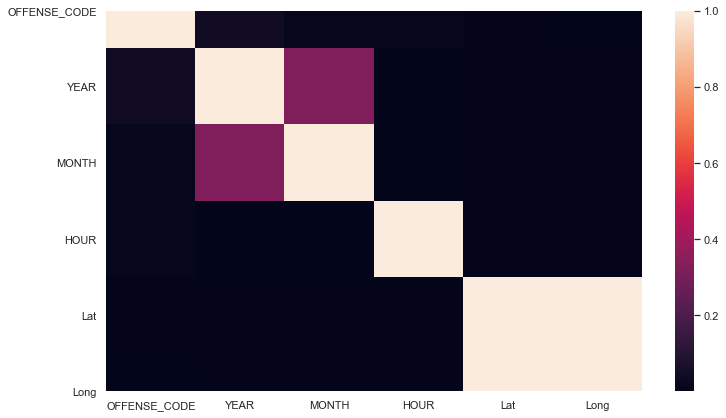

In [7]:
# Картинку отрисуем с помощью библиотеки seaborn
import seaborn as sns
# Подсчитаем корреляцию и возьмем модуль от нее
corr = data.corr().abs()
# Следующая команда устанавливает размер картинки (по умолчанию она довольно маленькая)
sns.set(rc={'figure.figsize':(12, 7)})
# Нарисуем картинку
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

![%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png](attachment:%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png)

Удалим из выборки признаки, высоко коррелирующие с другими признаками - зачем они нам?) Уберем еще один признак dateOfDeath, потому что он однозначно повторяет целевую переменную: если есть значение - значит, герой мертв.

Мы оставили один признак с высокой корреляцией - actual. Исходного описания к этому набору данных не было, поэтому нельзя однозначно сказать, что он означает, но, видимо, это некоторая "актуальность" персонажа, знак того, фигурирует ли он в данный момент в сюжете. Этот признак коррелирует с нашей целевой переменной, которую мы не используем в признаковом описании объектов, поэтому стоит его оставить. Забегая вперед, сразу можно сказать, что на таких данных шикарно будут работать линейные методы, о которых мы поговорим через пару занятий.

Посмотрим на признаки, которые остались после прореживания.

In [7]:
data.head()

,OFFENSE_CODE,DISTRICT,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long
0,619,B3,NaN,2019,8,Thursday,21,42.295764,-71.087560
1,3115,D4,NaN,2019,8,Thursday,21,42.339620,-71.076992
2,1402,NaN,NaN,2019,8,Thursday,21,NaN,NaN
3,3006,D4,NaN,2019,8,Thursday,19,42.344967,-71.063822
4,3201,D4,NaN,2019,8,Thursday,19,42.348406,-71.086883


Видим несколько колонок текстовых переменных. Посмотрим, сколько всего таких - выведем типы данных в каждой колонке.

In [18]:
data.dtypes

OFFENSE_CODE      int64
DISTRICT          int64
SHOOTING          int64
YEAR              int64
MONTH             int64
DAY_OF_WEEK       int64
HOUR              int64
Lat             float64
Long            float64
dtype: object

Текстовые признаки математическим методом не обработаешь. Посмотрим на значения, которые они принимают, чтобы придумать, что с ними делать.

In [9]:
data['DISTRICT'].value_counts()

B2     65597
C11    55382
D4     52947
B3     46498
A1     45874
C6     29897
D14    25768
E18    22580
E13    22447
E5     16982
A7     16565
A15     8365
Name: DISTRICT, dtype: int64

In [10]:
data['SHOOTING'].value_counts()

Y    1686
Name: SHOOTING, dtype: int64

Чем больше группа - тем больше вероятность того, что хоть кто-то в ней будет убит. Давайте заменим значения этого признака на количество героев в группе.

## Важно!
* На предыдущем шаге была допущена принципиальная ошибка, попробуйте понять, какая. Она была допущена умышленно, чтобы не мучить вас пока излишним питоном.

Если в книгах были указаны родственные связи героя, то это тоже может повлиять на исход его жизни. Закодируем бинарно наличие матери и наличие отца в тексте книг.

In [8]:
def week (value):
    weekdays = {
        'Monday' : 1,
        'Tuesday' : 2,
        'Wednesday' : 3, 
        'Thursday' : 4, 
        'Friday' : 5, 
        'Saturday' : 6, 
        'Sunday' : 7
    }
    return weekdays[value]

data['DAY_OF_WEEK'] = data['DAY_OF_WEEK'].apply(week)

В остальных текстовых переменных разброс значений более равномерный, поэтому дропнем их за ненадобностью.

In [9]:
def shoot_nans(value):
    if value == 'Y':
        return 1
    if pd.isnull(value):
        return 0
def dig(s):
    s_int = ''
    i = 0
    for i in range(len(s)):
        try:
            s_int += str(int(s[i]))
        except ValueError as err:
            continue
        return s_int
def distr_nans(value):
    sec = {
        'A': '1',
        'B': '2',
        'C': '3',
        'D': '4',
        'E': '5'
    }
    if pd.isnull(value):
        return 0
    else:
        return int(sec[value[0]]+dig(value))
    
def loc_nans(value):
    if pd.isnull(value):
        return 0
    else:
        return value*1000000

for col in ['SHOOTING']:
    data[col] = data[col].apply(shoot_nans)
for col in ['DISTRICT']:
    data[col]=data[col].apply(distr_nans)
for col in ['Lat', 'Long']:
    data[col]=data[col].apply(loc_nans)

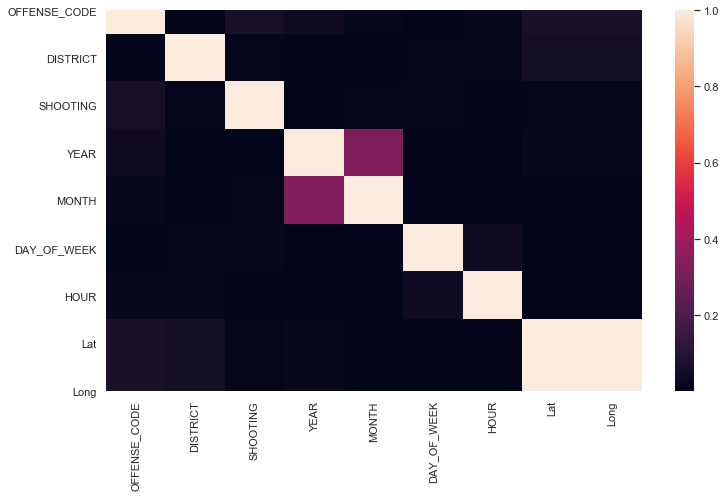

In [10]:
# Картинку отрисуем с помощью библиотеки seaborn
import seaborn as sns
# Подсчитаем корреляцию и возьмем модуль от нее
corr = data.corr().abs()
# Следующая команда устанавливает размер картинки (по умолчанию она довольно маленькая)
sns.set(rc={'figure.figsize':(12, 7)})
# Нарисуем картинку
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

У нас осталась единственная проблема с данными - пропущенные значения. Есть несколько подходов к заполнению пропусков - они показаны в презентации. Посмотрим, в каких колонках есть пропущенные значения.

In [11]:
data.isna().any()

OFFENSE_CODE    False
DISTRICT        False
SHOOTING        False
YEAR            False
MONTH           False
DAY_OF_WEEK     False
HOUR            False
Lat             False
Long            False
dtype: bool

Четыре из этих признаков - бинарные. Преобразоуем nan'ы в нечто равноудаленное от 0 и 1:

Отлично, теперь посмотрим на оставшийся признак age:

Что-то здесь неладно: видно двух персонажей с отрицательным возрастом.

Чтобы пока не ломать голову, приведем эти значения к nan:

Глянем на плотность распределения возрастов.

С распределением всё понятно, а у скольких героев возраст не указан?

Всего героев около 2000. И для 3/4 из них признак возраста имеет одно и то же значение. Взглянем, коррелирует ли он с целевой переменной.

Ни отсутствие возраста, ни конкретные значения не дают прямую зависимость с фактом неумерщвления персонажа. Уберем признак возраста.

## Настало время machine learning

Выделим в нашей выборке целевую переменную, а также разделим ее на тренировочную и тестовую.

In [12]:
X = data[data.columns[:-1]]
y = data['SHOOTING']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

Пора заняться делом. Будем проводить классификацию с помощью метода ближайших соседей.

In [16]:
# импортируем класс классификатора по ближайшим соседям
from sklearn.neighbors import KNeighborsClassifier

# создадим наш классификатор. Гиперпараметр у этого алгоритма один - количество соседей.
clf = KNeighborsClassifier(n_neighbors=8)
# обучим классификатор на тренировочной выборке
clf.fit(X_train, y_train)
# подсчитаем долю верных ответов алгоритма на тестовой выборке.
# Есть и другие метрики качества - о них будет рассказано на следующей лабе
clf.score(X_test, y_test)

0.9960976654113022

Посмотрим, как влияет гиперпараметр на качество классификации.

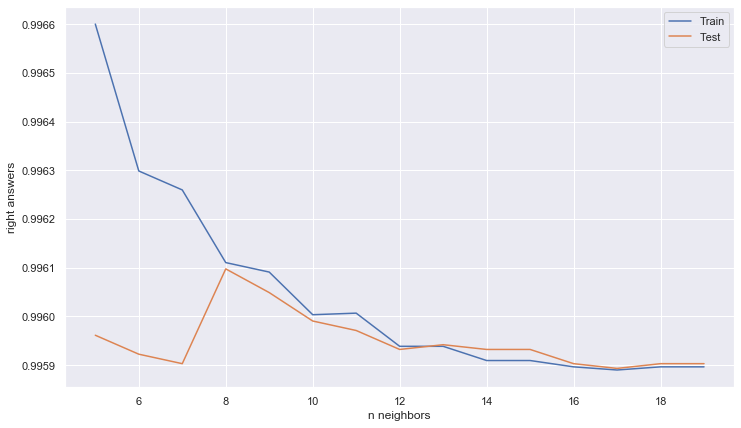

In [15]:
# Создадим пустой словарь. Будем добавлять в него значения наших "скоров". Ключами будет значение гиперпараметра,
# значениями - качество работы. Рассмотрим отдельно качество на тренировочной выборке и на тестовой.
train_scores = {}
test_scores = {}

# для n в диапазоне от 1 до 40 включительно
for n in range(5, 20):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации:
    current_train_score = clf.score(X_train, y_train)
    current_test_score = clf.score(X_test, y_test)
    # запишем его в наши словари
    train_scores[n] = current_train_score
    test_scores[n] = current_test_score

# нарисуем графики
plt.plot(list(train_scores.keys()), list(train_scores.values()), label='Train')
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Test')
plt.xlabel('n neighbors')
plt.ylabel('right answers')
plt.legend()
plt.show()

Какое количество соседей лучше всего брать для этой задачи?

Сейчас мы разобрали задачу классификации. Метод ближайших соседей также применим для регрессии. В этом случае вместе KNeighborsClassifier нужно использовать KNeighborsRegressor.